# Network Properties for Ecoli

Download the file Ecoli.txt that gives the gene network for E.Coli. It has an (undirected) edge whenever there is an interaction between the two genes.

## Import libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
g = nx.read_adjlist('data/Ecoli.txt', nodetype=int)

## Diameter

For this assignment, ignore if i cannot reach j.

### Using bultin function

In [3]:
%%timeit -r 1 -n 1 
diameters = list()

for component in nx.connected_components(g):
    diameters.append(nx.diameter(g.subgraph(component)))
    
print(max(diameters))

9
12.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Manual

In [4]:
def diameter(g):
    diam = -1

    for component in nx.connected_components(g):
        subgraph = g.subgraph(component)
        for i in component:
            for j in component:
                path_length = len(nx.shortest_path(subgraph, i, j)) - 1
                if path_length > diam:
                    diam = path_length
                    
    return diam
                    
diameter(g)

9

## Degree Distribution

In [8]:
def degree_distribution(g):
    distribution = dict()
    total_nodes = len(g.nodes())
    for node, degree in g.degree():
        distribution.setdefault(degree, 0)
        distribution[degree] += 1

    for degree in distribution:
        distribution[degree] /= total_nodes
        
    return distribution

distribution = degree_distribution(g)
print(distribution)

{3: 0.1412140575079872, 7: 0.019808306709265176, 11: 0.008306709265175719, 33: 0.0019169329073482429, 2: 0.2268370607028754, 18: 0.0006389776357827476, 4: 0.09520766773162939, 34: 0.0012779552715654952, 19: 0.0006389776357827476, 139: 0.0006389776357827476, 97: 0.0006389776357827476, 216: 0.0006389776357827476, 217: 0.0006389776357827476, 1: 0.3539936102236422, 8: 0.008306709265175719, 430: 0.0006389776357827476, 10: 0.003194888178913738, 5: 0.03642172523961661, 6: 0.06261980830670927, 157: 0.0006389776357827476, 221: 0.0006389776357827476, 115: 0.0006389776357827476, 25: 0.0012779552715654952, 49: 0.0006389776357827476, 277: 0.0006389776357827476, 30: 0.0006389776357827476, 9: 0.011501597444089457, 40: 0.0006389776357827476, 20: 0.0012779552715654952, 87: 0.0006389776357827476, 14: 0.0012779552715654952, 16: 0.0012779552715654952, 90: 0.0012779552715654952, 83: 0.0006389776357827476, 46: 0.0006389776357827476, 15: 0.0019169329073482429, 45: 0.0006389776357827476, 54: 0.000638977635782

Gamma: 1.0051160568647628


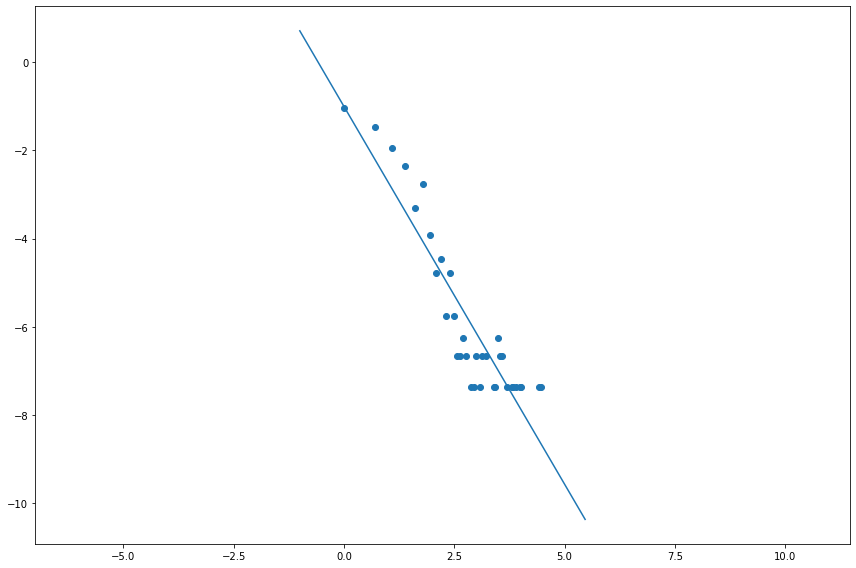

In [12]:
def plot_distribution(distribution, ax):

    degrees, freq = zip(*sorted(list(distribution.items()), key=lambda x: x[0]))

    # Omit some values
    degrees = degrees[:-10]
    freq = freq[:-10]
    
    model = LinearRegression().fit(np.log(degrees)[:, np.newaxis], np.log(freq))

    x = np.log(degrees)
    y = np.log(freq) 

    x0 = np.linspace(x.min() - 1, x.max() + 1, 1000)
    y0 = model.predict(x0[:, np.newaxis])
    ax.plot(x0, y0)
    ax.scatter(x, y)
    ax.axis('equal')
    
    return ax, -model.intercept_

fig, ax = plt.subplots(figsize=(12, 8))
ax, gamma = plot_distribution(distribution, ax)
plt.tight_layout()
print(f"Gamma: {gamma}")

## Clustering Coefficient

In [14]:
def cluster_coefficient(g):

    cluster_coefs_sum = 0
    total_nodes = len(g.degree)
    
    for node in g.nodes():
        if g.degree[node] >= 2:
            num_neighbor = g.degree[node]
            max_edges = num_neighbor * (num_neighbor - 1) / 2
            real_edges = len(nx.subgraph(g, nx.neighbors(g, node)).edges)
            coef = real_edges / max_edges
            cluster_coefs_sum += coef
            
    return cluster_coefs_sum / total_nodes
        
print(cluster_coefficient(g))


0.2116414939186282


# Page Rank in E. Coli

Download the file Ecoli-directed.txt that gives the gene regulatory network for E.Coli. It has a directed edge from gene u to gene v, if u controls v

Compute the pagerank for each gene, via the power-iteration method, assuming that d=0.1, that is with probability 0.1 we follow a random link, and with probability 0.9 an existing link from each node

In [50]:
g = nx.read_adjlist(
    'data/Ecoli-directed.txt', nodetype=int, 
    create_using=nx.DiGraph)

In [51]:
def is_adjacent(i, j):
    if j in g[i]:
        return 1.0
    return 0.0

In [52]:
def page_rank(g):

    n = len(g.nodes)
    d = 0.1

    N_r = np.ones((n, n)) / n

    N = np.fromfunction(np.vectorize(is_adjacent), shape=(n, n))
    cond = N.sum(axis=1) > 0
    N[cond] /= N[cond].sum(axis=1).reshape((-1, 1))
    N[~cond] = 1/n

    M = (1-d)*N + d*N_r
    
    # intitial vector
    p = np.ones(n)
 
    while True:
        p_new = M.T @ p
        i = p_new.argmax()
        p_new = p_new / p[i]
        if np.linalg.norm(p_new - p) <= 0.001:
            p = p_new
            break
        p = p_new
        
    p = p / np.linalg.norm(p)
    
    return p
    
p = page_rank(g)

In [53]:
print(f"Top 10 gene: {p.argsort()[-10:]}")

Top 10 gene: [ 681  478 1555 1556 1353 1354   19 1155 1154  978]
